In [1]:
import numpy as np

import cv2
import rawpy

from matplotlib import pyplot as plt

import os
import sys

In [2]:
in_fp = "../data/SID/Sony/long/00021_00_10s.ARW"

In [3]:
os.path.exists(in_fp)

True

In [4]:
raw = rawpy.imread(in_fp)
print(raw.__dir__())

['__new__', '__enter__', '__exit__', 'close', 'open_file', 'open_buffer', 'unpack', 'unpack_thumb', 'raw_value', 'raw_value_visible', 'raw_color', 'dcraw_process', 'dcraw_make_mem_image', 'dcraw_make_mem_thumb', 'extract_thumb', 'postprocess', 'raw_type', 'raw_image', 'raw_image_visible', 'sizes', 'num_colors', 'color_desc', 'raw_colors', 'raw_colors_visible', 'raw_pattern', 'camera_whitebalance', 'daylight_whitebalance', 'black_level_per_channel', 'white_level', 'camera_white_level_per_channel', 'color_matrix', 'rgb_xyz_matrix', 'tone_curve', '__doc__', '__pyx_vtable__', '__reduce__', '__setstate__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__init__', '__reduce_ex__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [5]:
def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    #XXX read black level
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    # RG
    # GB
    out = np.concatenate((im[0:H:2, 0:W:2, :], # R
                          im[0:H:2, 1:W:2, :], # G
                          im[1:H:2, 1:W:2, :], # B
                          im[1:H:2, 0:W:2, :]), axis=2) # G
    return out

In [6]:
data_lowlight = pack_raw(raw)

In [7]:
data_lowlight.shape

(1424, 2128, 4)

In [8]:
def select_green(im, green):
    if green != 0 and green != 1: 
        raise ValueError
    return np.concatenate([im[...,0:1],
                           im[...,1:2 if not green else 3:4],
                           im[...,2:3]], 
                        axis=-1)

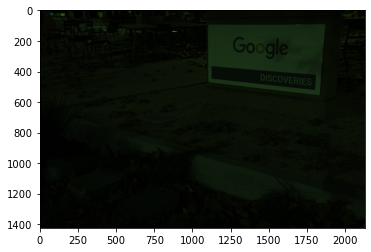

In [9]:
plt.imshow(select_green(data_lowlight, 0))

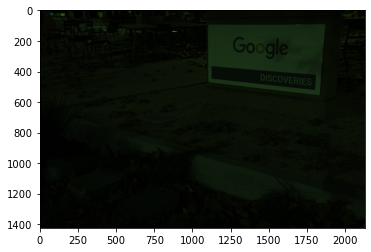

In [10]:
plt.imshow(select_green(data_lowlight, 1))

In [11]:
raw.camera_whitebalance

[1984.0, 1024.0, 2288.0, 1024.0]

In [12]:
raw.rgb_xyz_matrix[:3,:3]

array([[ 0.5838, -0.143 , -0.0246],
       [-0.3497,  1.1477,  0.2297],
       [-0.0748,  0.1885,  0.5778]], dtype=float32)

In [13]:
xyz_from_rgb = np.array([[0.412453, 0.357580, 0.180423],
                         [0.212671, 0.715160, 0.072169],
                         [0.019334, 0.119193, 0.950227]])

rgb_from_xyz = np.linalg.inv(xyz_from_rgb)

In [14]:
wb = raw.camera_whitebalance[1]/np.array(raw.camera_whitebalance)
data_lowlight_wb = data_lowlight 

In [15]:
def convert_rgbg(matrix, arr):
    result1 = arr[:,:,:3] @ matrix.T.astype(arr.dtype)
    return result1[:,:,:3]

def convert_rgbg(matrix, arr):
    result1 = arr[:,:,:3] @ matrix.T.astype(arr.dtype)
    result2 = np.concatenate([arr[:,:,0:1],
                              arr[:,:,3:4],
                              arr[:,:,2:3]],
                             axis=-1) @ matrix.T.astype(arr.dtype)
    return np.concatenate([result1[:,:,:3],result2[:,:,1:2]], axis=-1)

In [16]:
xyz_from_camerargb = np.linalg.inv(raw.rgb_xyz_matrix[:3,:3])
rgb_from_camerargb = rgb_from_xyz@xyz_from_camerargb
data_lowlight_wb_rgb = convert_rgbg(rgb_from_camerargb, data_lowlight_wb)
data_lowlight_wb_rgb.shape

(1424, 2128, 4)

In [17]:
def apply_gamma(im, inplace=False):
    if inplace:
        arr = im
    else:
        arr = im.copy()
    mask = arr > 0.0031308
    arr[mask] = 1.055 * np.power(arr[mask], 1 / 2.4) - 0.055
    arr[~mask] *= 12.92
    np.clip(arr, 0, 1, out=arr)
    return arr

In [18]:
data_lowlight_wb_rgb_gamma = apply_gamma(data_lowlight_wb_rgb, )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


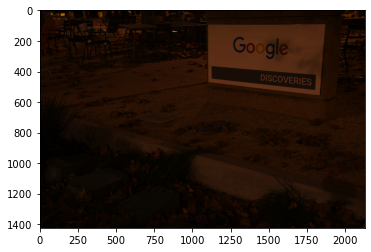

In [19]:
plt.imshow(select_green(data_lowlight_wb_rgb, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


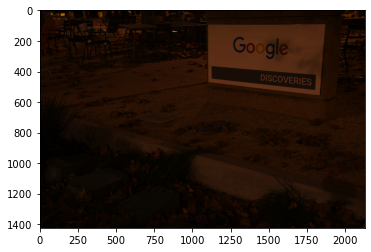

In [20]:
plt.imshow(select_green(data_lowlight_wb_rgb, 1))

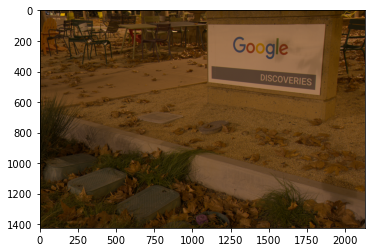

In [21]:
plt.imshow(select_green(data_lowlight_wb_rgb_gamma, 0))

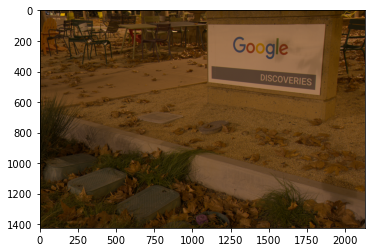

In [22]:
plt.imshow(select_green(data_lowlight_wb_rgb_gamma, 1))